# Glucose-6-Phosphate Dehydrogenase, reversible (G6PDH2r)
To construct the glucose-6-phosphate dehydrogenase module, first we import <b>masspy</b> and other essential packages. Constants used throughout the notebook are also defined.

In [1]:
from os import path

import matplotlib.pyplot as plt

from scipy import optimize

import sympy as sym

from cobra import DictList

from mass.util.matrix import matrix_rank
from mass import MassMetabolite, Simulation, UnitDefinition
from mass.enzyme_modules import EnzymeModule
from mass.io import json, sbml
from mass.util import Keq2k, k2Keq, strip_time, qcqa_model

Note that the total enzyme concentration of G6PDH2r is \\(1 \mu M = 0.001 mM\\).

For the construction of the <font color=#4682B4>EnzymeModule</font> for G6PDH2r, the following assumptions were made:

1. The enzyme behaves like a monomer.
2. The enzyme binding and catalyzation of substrates occurs in an ordered sequential mechanism.
3. The enzyme experiences product inhibtion, and is competitively inhibited by ATP.

## Module Construction
The first step of creating the G6PDH2r module is to define the <font color=#4682B4>EnzymeModule</font>. The <font color=#4682B4>EnzymeModule</font> is an extension of the <font color=#4682B4>MassModel</font>, with additional enzyme-specific attributes that aid in the construction, validation, and utilization of the module.

__Note:__ All <font color=#4682B4>EnzymeModule</font> specific attributes start will start the prefix "enzyme" or "enzyme_module".

In [2]:
G6PDH2r = EnzymeModule("G6PDH2r", name="Glucose 6-phosphate dehydrogenase", subsystem="PentosePhosphatePathway")

Academic license - for non-commercial use only


### Metabolites
#### Ligands
The next step is to define all of the metabolites using the <font color=#4682B4>MassMetabolite</font> object. For <font color=#4682B4>EnzymeModules</font>, the <font color=#4682B4>MassMetabolite</font> objects will be refered to as ligands, for these <font color=#4682B4>MassMetabolite</font> form a complex with the enzyme to serve some biological purpose. Some considerations for this step include the following:

1. It is important to use a clear and consistent format for identifiers and names when defining the <font color=#4682B4>MassMetabolite</font> objects for various reasons, some of which include improvements to model clarity and utility, assurance of unique identifiers (required to add metabolites to the model), and consistency when collaborating and communicating with others. 


2. In order to ensure our model is physiologically accurate, it is important to provide the <font color=#B22222>formula</font> argument with a string representing the chemical formula for each metabolite, and the <font color=#B22222>charge</font> argument with an integer representing the metabolite's ionic charge (Note that neutrally charged metabolites are provided with 0). These attributes can always be set later if necessary using the <font color=#1E90FF>formula</font> and <font color=#1E90FF>charge</font> attribute setter methods.


3. To indicate that the cytosol is the cellular compartment in which the reactions occur, the string "c" is provided to the <font color=#B22222>compartment</font> argument.

This model will be created using identifiers and names found in the [BiGG Database](http://bigg.ucsd.edu/).

The ligands correspond to the activators, inhibitors, cofactors, substrates, and products involved in the enzyme catalyzed reaction. In this model, there are 6 species which must be considered.

In [3]:
g6p_c = MassMetabolite(
    "g6p_c",
    name="D-Glucose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c")
_6pgl_c = MassMetabolite(
    "_6pgl_c",
    name="6-Phospho-D-gluco-1,5-lactone",
    formula="C6H9O9P",
    charge=-2,
    compartment="c")
nadp_c = MassMetabolite(
    "nadp_c",
    name="Nicotinamide adenine dinucleotide phosphate",
    formula="C21H25N7O17P3",
    charge=-3,
    compartment="c")
nadph_c = MassMetabolite(
    "nadph_c",
    name="Nicotinamide adenine dinucleotide phosphate - reduced",
    formula="C21H26N7O17P3",
    charge=-4,
    compartment="c")
atp_c = MassMetabolite(
    "atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c")
h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c")

After generating the ligands, they are added to the <font color=#4682B4>EnzymeModule</font> through the <font color=#00008B>add_metabolites</font> method. The ligands of the <font color=#4682B4>EnzymeModule</font> can be viewed as a DictList through the <font color=#1E90FF>enzyme_module_ligands</font> attribute.

In [4]:
G6PDH2r.add_metabolites([g6p_c, _6pgl_c, nadp_c, nadph_c, atp_c, h_c])
# Access DictList of ligands and print
print("All {0} Ligands: {1}\n".format(
    G6PDH2r.id, "; ".join([m.id for m in G6PDH2r.enzyme_module_ligands])))

All G6PDH2r Ligands: g6p_c; _6pgl_c; nadp_c; nadph_c; atp_c; h_c



The <font color=#1E90FF>enzyme_module_ligands_categorized</font> attribute can be used to assign metabolites to groups of user-defined categories by providing a dictionary where keys are the categories and values are the metabolites. Note that any metabolite can be placed in more than one category.

In [5]:
G6PDH2r.enzyme_module_ligands_categorized =  {
    "Substrates": g6p_c,
    "Cofactors": nadp_c,
    "Inhibitors": atp_c,
    "Products": [_6pgl_c, nadph_c, h_c]}

# Access DictList of ligands and print
print("All {0} ligands ({1} total):\n{2}\n".format(
    G6PDH2r.id, len(G6PDH2r.enzyme_module_ligands),
    str([m.id for m in G6PDH2r.enzyme_module_ligands])))

# Access categorized attribute for ligands and print
for group in G6PDH2r.enzyme_module_ligands_categorized:
    print("{0}: {1}".format(
        group.id, str([m.id for m in group.members])))

All G6PDH2r ligands (6 total):
['g6p_c', '_6pgl_c', 'nadp_c', 'nadph_c', 'atp_c', 'h_c']

Substrates: ['g6p_c']
Cofactors: ['nadp_c']
Inhibitors: ['atp_c']
Products: ['h_c', 'nadph_c', '_6pgl_c']


#### EnzymeModuleSpecies

The next step is to define the various states of the enzyme and enzyme-ligand complexes. These states can be represented through an <font color=#4682B4>EnzymeModuleSpecies</font> object. Just like how <font color=#4682B4>EnzymeModules</font> extend <font color=#4682B4>MassModels</font>, the <font color=#4682B4>EnzymeModuleSpecies</font> extend <font color=#4682B4>MassMetabolites</font>, giving them the same functionality as a <font color=#4682B4>MassMetabolite</font>. However, there are three important additional attrubutes that are specific to the <font color=#4682B4>EnzymeModuleSpecies</font>.

* The first attribute is the <font color=#1E90FF>enzyme_module_id</font>. It is meant to hold the identifier or name of the <font color=#4682B4>EnzymeModule</font> that the <font color=#4682B4>EnzymeModuleSpecies</font> belongs to.
* The second and third attributes are the <font color=#1E90FF>bound_catalytic</font> and <font color=#1E90FF>bound_effectors</font> attributes, designed to contain metabolites bound to the active/catalytic site and effector metabolites bound to the enzyme, respectively. 
* Automatic generation of the <font color=#1E90FF>name</font>, <font color=#1E90FF>formula</font>, and <font color=#1E90FF>charge</font> attributes attributes utilize the <font color=#1E90FF>bound_catalytic</font> and <font color=#1E90FF>bound_effectors</font> attributes, which can aid in identification of <font color=#4682B4>EnzymeModuleSpecies</font> and mass and charge balancing of the reactions.

The most convenient way to make an <font color=#4682B4>EnzymeModuleSpecies</font> is through the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.make_enzyme_module_species</font> method. There are several reasons to use this method to generate the <font color=#4682B4>EnzymeModuleSpecies</font>:

1. The only requirement to creating an <font color=#4682B4>EnzymeModuleSpecies</font> is an identifier.
2. A string can optionally be provided for the <font color=#B22222>name</font> argument to set the corresponding <font color=#1E90FF>name</font> attribute, or it can automatically be generated and set by setting the string "Automatic" (case sensitve). 
3. The <font color=#1E90FF>enzyme_module_id</font>, <font color=#1E90FF>formula</font> and <font color=#1E90FF>charge</font> attributes are set based on the identifier of the EnzymeModule and the MassMetabolite objects found in <font color=#1E90FF>bound_catalytic</font> and <font color=#1E90FF>bound_effectors</font>
4. Just like the <font color=#1E90FF>enzyme_module_ligands_categorized</font> attribute, there is the <font color=#1E90FF>enzyme_module_species_categorized</font> attribute that behaves in a similar manner. Categories can be set at the time of construction by providing a string or a list of strings to the <font color=#B22222>categories</font> argument. 
5. <font color=#4682B4>EnzymeModuleSpecies</font> are automatically added to the <font color=#4682B4>EnzymeModule</font> once created.

For this module, there are 7 <font color=#4682B4>EnzymeModuleSpecies</font> that must be created.

In [6]:
G6PDH2r.make_enzyme_module_species(
    "g6pdh2r_c",
    name="Automatic",
    categories="Free",
    compartment="c")
G6PDH2r.make_enzyme_module_species(
    "g6pdh2r_G_c",
    name="Automatic",
    categories="Free",
    bound_catalytic={g6p_c: 1},
    compartment="c")
G6PDH2r.make_enzyme_module_species(
    "g6pdh2r_GN_c",
    name="Automatic",
    categories="Free",
    bound_catalytic={g6p_c: 1, nadp_c: 1},
    compartment="c")
G6PDH2r.make_enzyme_module_species(
    "g6pdh2r_GN_P_c",
    name="Automatic",
    categories="Free",
    bound_catalytic={_6pgl_c: 1, nadph_c: 1},
    compartment="c")
G6PDH2r.make_enzyme_module_species(
    "g6pdh2r_G_P_c",
    name="Automatic",
    categories="Free",
    bound_catalytic={_6pgl_c: 1},
    compartment="c")
G6PDH2r.make_enzyme_module_species(
    "g6pdh2r_N_PI_c",
    name="Automatic",
    categories="Inhibited",
    bound_catalytic={nadph_c: 1},
    compartment="c")
G6PDH2r.make_enzyme_module_species(
    "g6pdh2r_A_CI_c",
    name="Automatic",
    categories="Inhibited",
    bound_catalytic={atp_c: 1},
    compartment="c")

# Access DictList of enzyme module species and print
print("All {0} enzyme module species ({1} total):\n{2}\n".format(
    G6PDH2r.id, len(G6PDH2r.enzyme_module_species),
    str([m.id for m in G6PDH2r.enzyme_module_species])))

# Access categorized attribute for enzyme module species and print
for group in G6PDH2r.enzyme_module_species_categorized:
    print("{0}: {1}\n".format(
        group.id, str([m.id for m in group.members])))

All G6PDH2r enzyme module species (7 total):
['g6pdh2r_c', 'g6pdh2r_G_c', 'g6pdh2r_GN_c', 'g6pdh2r_GN_P_c', 'g6pdh2r_G_P_c', 'g6pdh2r_N_PI_c', 'g6pdh2r_A_CI_c']

Free: ['g6pdh2r_G_P_c', 'g6pdh2r_G_c', 'g6pdh2r_c', 'g6pdh2r_GN_P_c', 'g6pdh2r_GN_c']

Inhibited: ['g6pdh2r_A_CI_c', 'g6pdh2r_N_PI_c']



## Reactions
### EnzymeModuleReactions
Once all of the <font color=#4682B4>MassMetabolites</font> and <font color=#4682B4>EnzymeModuleSpecies</font> have been created, the next step is to define all of the enzyme-ligand binding reactions and conformation trasitions that occur in its mechanism.

These reactions can be represented through an <font color=#4682B4>EnzymeModuleReaction</font> object. As with the previous enzyme objects,  <font color=#4682B4>EnzymeModuleReactions</font> extend <font color=#4682B4>MassReactions</font> to maintain the same functionality. However, as with the <font color=#4682B4>EnzymeModuleSpecies</font>, the <font color=#4682B4>EnzymeModuleReaction</font> has additional enzyme-specific attributes, such as the <font color=#1E90FF>enzyme_module_id</font>.

The most conveient way to make an <font color=#4682B4>EnzymeModuleReaction</font> is through the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.make_enzyme_module_reaction</font> method. There are several reasons to use this method to generate the EnzymeModuleReactions:

1. The only requirement to creating an <font color=#4682B4>EnzymeModuleReaction</font> is an identifier.
2. A string can optionally be provided for the <font color=#B22222>name</font> argument to set the corresponding <font color=#1E90FF>name</font> attribute, or it can automatically be generated and set by setting the string "Automatic" (case sensitve). 
3. There is an <font color=#1E90FF>enzyme_module_reactions_categorized</font> attribute that behaves in a similar manner as the previous categorized attributes. Categories can be set at the time of construction by providing a string or a list of strings to the <font color=#B22222>categories</font> argument. 
4. <font color=#4682B4>MassMetabolites</font> and <font color=#4682B4>EnzymeModuleSpecies</font> that already exist in the <font color=#4682B4>EnzymeModule</font> can be directly added to the newly created <font color=#4682B4>EnzymeModuleReaction</font> by providing a dictionary to the optional <font color=#B22222>metabolites_to_add</font> argument using string identifiers (or the objects) as keys and their stoichiometric coefficients as the values.
5. <font color=#4682B4>EnzymeModuleReactions</font> are automatically added to the <font color=#4682B4>EnzymeModule</font> once created.

For this module, there are 7 <font color=#4682B4>EnzymeModuleReactions</font> that must be created.

In [7]:
G6PDH2r.make_enzyme_module_reaction(
    "G6PDH2r_1",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="product_inhibition",
    metabolites_to_add={
        "g6pdh2r_c": -1,
        "nadph_c": -1,
        "g6pdh2r_N_PI_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    "G6PDH2r_2",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="product_inhibition",
    metabolites_to_add={
        "g6pdh2r_c": -1,
        "atp_c": -1,
        "g6pdh2r_A_CI_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    "G6PDH2r_3",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="g6p_c_binding",
    metabolites_to_add={
        "g6pdh2r_c": -1,
        "g6p_c": -1,
        "g6pdh2r_G_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    "G6PDH2r_4",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="_6pgl_c_release",
    metabolites_to_add={
        "g6pdh2r_G_P_c": -1,
        "_6pgl_c": 1,
        "g6pdh2r_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    "G6PDH2r_5",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="nadp_c_binding",
    metabolites_to_add={
        "g6pdh2r_G_c": -1,
        "nadp_c": -1,
        "g6pdh2r_GN_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    "G6PDH2r_6",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="nadph_c_release",
    metabolites_to_add={
        "g6pdh2r_GN_P_c": -1,
        "nadph_c": 1,
        "g6pdh2r_G_P_c": 1})

G6PDH2r.make_enzyme_module_reaction(
    "G6PDH2r_7",
    name="Automatic",
    subsystem="Pentose Phosphate Pathway",
    reversible=True,
    categories="catalyzation",
    metabolites_to_add={
        "g6pdh2r_GN_c": -1,
        "g6pdh2r_GN_P_c": 1,
        "h_c": 1})

# Access DictList of enzyme module reactions and print
print("All {0} enzyme module reactions ({1} total):\n{2}\n".format(
    G6PDH2r.id, len(G6PDH2r.enzyme_module_reactions),
    str([m.id for m in G6PDH2r.enzyme_module_reactions])))

# Access categorized attribute for enzyme module reactions and print
for group in G6PDH2r.enzyme_module_reactions_categorized:
    print("{0}: {1}\n".format(
        group.id, str([m.id for m in group.members])))

All G6PDH2r enzyme module reactions (7 total):
['G6PDH2r_1', 'G6PDH2r_2', 'G6PDH2r_3', 'G6PDH2r_4', 'G6PDH2r_5', 'G6PDH2r_6', 'G6PDH2r_7']

product_inhibition: ['G6PDH2r_2', 'G6PDH2r_1']

g6p_c_binding: ['G6PDH2r_3']

_6pgl_c_release: ['G6PDH2r_4']

nadp_c_binding: ['G6PDH2r_5']

nadph_c_release: ['G6PDH2r_6']

catalyzation: ['G6PDH2r_7']



## The Steady State
### Solve steady state concentrations symbolically
To determine the steady state of the enzyme, a dictionary of the ordinary differential equations as symbolic expressions for each of the <font color=#4682B4>EnzymeModuleSpecies</font>. 

For handling of all symbolic expressions, the <b>sympy</b> package is used.

In [8]:
ode_dict = {
    sym.Symbol(enzyme_module_species.id): sym.Eq(strip_time(enzyme_module_species.ode))
    for enzyme_module_species in G6PDH2r.enzyme_module_species}

rank = matrix_rank(G6PDH2r.S[6:])
print("Rank Deficiency: {0}".format(len(ode_dict) - rank))

Rank Deficiency: 1


In order to solve the system of ODEs for the steady state concentrations, an additional equation is required due to the rank deficiency of the stoichiometric matrix. Therefore, the equation for the steady state flux through the enzyme, which will be referred to as the "enzyme net flux equation", must be defined. 

To define the enzyme net flux equation, the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.make_enzyme_netflux_equation</font> class method can be used. 

* This equation is made by providing a reaction, or a list of reactions to add together.
* Passing a bool to <font color=#B22222>use_rates</font> argument determines whether a symbolic equation is a summation of the flux symbols returned by <font color=#4682B4>EnzymeModuleReaction</font><font color=#1E90FF>.flux_symbol_str</font>, or a summation of the rates laws for those reactions.
* The <font color=#B22222>update_enzyme</font> argument determines whether the new rate equation is set in the <font color=#1E90FF>enzyme_net_flux_equation</font> attribute.

The flux through the enzyme typically corresponds to the sum of the fluxes through the catalytic reaction steps.
Because the catalyzation reactions were assigned to the "catalyzation" cateogry, they can be accessed through the <font color=#1E90FF>enzyme_module_reactions_categorized</font> attribute to create the equation for \\(v_{\mathrm{G6PDH2r}}\\).

In [9]:
reactions = G6PDH2r.enzyme_module_reactions_categorized.get_by_id(
    "catalyzation").members
G6PDH2r.make_enzyme_net_flux_equation(
    reactions,
    use_rates=True, update_enzyme=True)
sym.pprint(G6PDH2r.enzyme_net_flux_equation)

            kf_G6PDH2r_7⋅(Keq_G6PDH2r_7⋅g6pdh2r_GN_c(t) - g6pdh2r_GN_P_c(t))
v_G6PDH2r = ────────────────────────────────────────────────────────────────
                                     Keq_G6PDH2r_7                          


The next step is to identify equations for the unknown concentrations in each reaction. These equations will need to be solved with a dependent variable before accounting for the enzyme net flux equation. The completely free form of the enzyme with no bound species will be treated as the dependent variable. 

To verify that all equations are in terms of the rate parameters, ligand concentrations, and the dependent variable, the solutions can be iterated through using the atoms method to identify the equation arguments. 

There should be no <font color=#4682B4>EnzymeModuleSpecies</font> identifiers with the exception of the dependent variable. 

In [10]:
# Get enzyme module species
enzyme_module_species = G6PDH2r.enzyme_module_species.copy()

enzyme_solutions = {}
for enzyme_module_specie in enzyme_module_species:
    # Skip dependent variable
    if "g6pdh2r_c" == str(enzyme_module_specie):
        continue
    else:
        enzyme_module_specie = sym.Symbol(enzyme_module_specie.id)
    # Solve for the enzyme form and update the solution dictionary
    sol = list(sym.solveset(ode_dict[enzyme_module_specie].subs(enzyme_solutions), enzyme_module_specie))
    enzyme_solutions[enzyme_module_specie] = sol.pop()
    enzyme_solutions.update({enzyme_module_specie: sol.subs(enzyme_solutions) 
                             for enzyme_module_specie, sol in enzyme_solutions.items()})
args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print(args)

{Keq_G6PDH2r_2, Keq_G6PDH2r_5, kf_G6PDH2r_3, kf_G6PDH2r_6, Keq_G6PDH2r_3, kf_G6PDH2r_4, _6pgl_c, kf_G6PDH2r_5, nadp_c, g6p_c, atp_c, Keq_G6PDH2r_4, kf_G6PDH2r_7, Keq_G6PDH2r_1, nadph_c, g6pdh2r_c, Keq_G6PDH2r_6, Keq_G6PDH2r_7}


The enzyme net flux equation can then be utilized as the last equation required to solve for the final unknown concentration variable in terms of the rate and equilibrium constants, allowing for all of the concentration variables to be defined in terms of the parameters and ligand concentrations. Once the unknown variable has been solved for, the solution can be substituted back into the other equations. Because <b>sympy</b><font color=#8B008B>.solveset</font> function expects the input equations to be equal to 0, the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.enzyme_net_flux_error</font> method with the <font color=#B22222>use_values</font>  argument set to False to get the appropriate expression.

In [11]:
enzyme_net_flux_equation = strip_time(G6PDH2r.enzyme_net_flux_error(False))
print("Enzyme Net Flux Equation\n" + "-"*24)
sym.pprint(enzyme_net_flux_equation)

# Solve for last unknown concentration symbolically
sol = sym.solveset(enzyme_net_flux_equation.subs(enzyme_solutions), "g6pdh2r_c")

# Update solution dictionary with the new solution
enzyme_solutions[sym.Symbol("g6pdh2r_c")] = list(sol)[0]

# Update solutions with free variable solutions
enzyme_solutions = {
    enzyme_module_species: sym.simplify(solution.subs(enzyme_solutions))
    for enzyme_module_species, solution in enzyme_solutions.items()}

args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print("\n", args)

Enzyme Net Flux Equation
------------------------
            kf_G6PDH2r_7⋅(Keq_G6PDH2r_7⋅g6pdh2r_GN_c - g6pdh2r_GN_P_c)
v_G6PDH2r - ──────────────────────────────────────────────────────────
                                  Keq_G6PDH2r_7                       



 {Keq_G6PDH2r_2, kf_G6PDH2r_6, kf_G6PDH2r_3, kf_G6PDH2r_4, Keq_G6PDH2r_3, _6pgl_c, Keq_G6PDH2r_5, kf_G6PDH2r_5, v_G6PDH2r, g6p_c, nadp_c, atp_c, Keq_G6PDH2r_4, kf_G6PDH2r_7, Keq_G6PDH2r_1, nadph_c, Keq_G6PDH2r_6, Keq_G6PDH2r_7}


#### Numerical Values
At this point, numerical values are defined for the dissociation constants and the concentrations of the substrates, cofactors, activators, and inhibitors. Providing these numerical values will speed up the subsequent calculations. 

To do this, experimental data is used to define the dissociations constants for the different binding steps under the QEA assumption. The concentrations of the non-enzyme species are taken from the glycolysis model. 

Experimental data gives the following for the dissociation constants: 

$$K_{i, \text{NADPH}} = 0.024,\ K_{i, \text{ATP}} = 0.044,\ K_{\text{G6P}} = 0.027,\ K_{\text{GL6P}} = 0.050,\ K_{\text{NADP}} = 0.019,\ K_{\text{NADPH}} = 0.0105$$ 

which gives us a value of $K_{\text{G6PDH2r}} = \frac{1000}{\frac{K_{\text{GL6P}}K_{\text{NADPH}}}{K_{\text{G6P}}K_{\text{NADP}}}} = \frac{1000}{\frac{0.050\ *\ 0.0105}{0.027\ *\ 0.019}}$ for the catalyzation step.

In [12]:
numerical_values = {}

# Get ligand IDs
ligand_ids = sorted([str(ligand) for ligand in G6PDH2r.enzyme_module_ligands])
parameter_ids = [r.Keq_str for r in G6PDH2r.enzyme_module_reactions]
print("Ligand IDs: " + str(ligand_ids))
print("Parameter IDs: " + str(parameter_ids))

# Load the glycolysis model and hemoglobin model to extract steady state values
glycolysis = json.load_json_model(path.realpath(path.join("models", "Glycolysis.json")))
ppp = json.load_json_model(path.realpath(path.join("models", "PentosePhosphatePathway.json")))
fullppp = glycolysis.merge(ppp)

# Get the steady state flux value and add to numerical values
G6PDH2r.enzyme_net_flux = fullppp.reactions.get_by_id(G6PDH2r.id).steady_state_flux
numerical_values.update({G6PDH2r.enzyme_flux_symbol_str: G6PDH2r.enzyme_net_flux})

# Get the steady state concentration values and add to numerical values
initial_conditions = {
    str(ligand): fullppp.initial_conditions[fullppp.metabolites.get_by_id(ligand)]
    for ligand in ligand_ids}
numerical_values.update(initial_conditions)

# Define parameter values and add to numerical values
G6PDH2r.enzyme_module_reactions.G6PDH2r_1.Keq = 1/0.024
G6PDH2r.enzyme_module_reactions.G6PDH2r_2.Keq = 1/0.044
G6PDH2r.enzyme_module_reactions.G6PDH2r_3.Keq = 1/0.027
G6PDH2r.enzyme_module_reactions.G6PDH2r_4.Keq = 0.050
G6PDH2r.enzyme_module_reactions.G6PDH2r_5.Keq = 1/0.019
G6PDH2r.enzyme_module_reactions.G6PDH2r_6.Keq = 0.0105
G6PDH2r.enzyme_module_reactions.G6PDH2r_7.Keq = 1000/((0.05*0.0105)/(0.019*0.027))

numerical_values.update({reaction.Keq_str: reaction.Keq 
                         for reaction in G6PDH2r.enzyme_module_reactions})
# Display numerical values
for k, v in numerical_values.items():
    print("{0} = {1}".format(k, v))

Ignoring reaction 'SK_h_c' since it already exists.


Ignoring reaction 'SK_h2o_c' since it already exists.


Ligand IDs: ['_6pgl_c', 'atp_c', 'g6p_c', 'h_c', 'nadp_c', 'nadph_c']
Parameter IDs: ['Keq_G6PDH2r_1', 'Keq_G6PDH2r_2', 'Keq_G6PDH2r_3', 'Keq_G6PDH2r_4', 'Keq_G6PDH2r_5', 'Keq_G6PDH2r_6', 'Keq_G6PDH2r_7']
v_G6PDH2r = 0.21
_6pgl_c = 0.00175424
atp_c = 1.6
g6p_c = 0.0486
h_c = 8.99757e-05
nadp_c = 0.0002
nadph_c = 0.0658
Keq_G6PDH2r_1 = 41.666666666666664
Keq_G6PDH2r_2 = 22.72727272727273
Keq_G6PDH2r_3 = 37.03703703703704
Keq_G6PDH2r_4 = 0.05
Keq_G6PDH2r_5 = 52.631578947368425
Keq_G6PDH2r_6 = 0.0105
Keq_G6PDH2r_7 = 977.1428571428569


The last part of this step is to simplify the solutions for the enzyme forms and, as a QCQA, ensure that only rate constants are the only symbolic arguments in the solutions. 

In [13]:
# Substitute values into equations
enzyme_solutions = {
    enzyme_module_species: sym.simplify(solution.subs(numerical_values))
    for enzyme_module_species, solution in enzyme_solutions.items()}

args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print(args)

{kf_G6PDH2r_7, kf_G6PDH2r_6, kf_G6PDH2r_3, kf_G6PDH2r_4, kf_G6PDH2r_5}


### Determine rate constants
#### Total Enzyme Concentration and $r_{T}$ 
After solving for the enzyme forms, the next step is to define equations for the total enzyme concentration and for the fraction of the enzyme in the T state. These two equations can be used as constraints for determining the rate parameters. To view the equation for the total enzyme concentration, we can use the <font color=#4682B4>EnzymeModule</font><font color=1E90FF>.enzyme_concentration_total_equation</font> property.

In [14]:
sym.pprint(G6PDH2r.enzyme_concentration_total_equation)

G6PDH2r_Total = g6pdh2r_A_CI_c(t) + g6pdh2r_GN_P_c(t) + g6pdh2r_GN_c(t) + g6pd
h2r_G_P_c(t) + g6pdh2r_G_c(t) + g6pdh2r_N_PI_c(t) + g6pdh2r_c(t)


The total concentration of G6PDH2r is 1 \\(\mu\\) M (=0.001 mM). The <font color=#4682B4>EnzymeModule</font><font color=1E90FF>.enzyme_concentration_total</font> atrribute can be used to set and store this concentration.

In [15]:
G6PDH2r.enzyme_concentration_total = 1e-3
print(G6PDH2r.enzyme_concentration_total)

0.001


To determine the rate constants, an optimization problem where the objective function is to minimize the error between the measured and calculated total enzyme concentrations. To create the objective function, the <font color=#4682B4>EnzymeModule</font><font color=#00008B>.enzyme_concentration_total_error</font> method with the <font color=#B22222>use_values</font> argument set as False to get the symbolic expression of the constraint. 

In [16]:
enzyme_total_constraint = abs(strip_time(G6PDH2r.enzyme_concentration_total_error(use_values=False)))
sym.pprint(enzyme_total_constraint)

│-G6PDH2r_Total + g6pdh2r_A_CI_c + g6pdh2r_GN_P_c + g6pdh2r_GN_c + g6pdh2r_G_P
_c + g6pdh2r_G_c + g6pdh2r_N_PI_c + g6pdh2r_c│


Substitute the solutions for the enzyme forms to get an equation for the error in the enzyme total concentration in terms of the rate constants.

In [17]:
# Substitute value for enzyme concentration total
enzyme_total_constraint = enzyme_total_constraint.subs({G6PDH2r.enzyme_total_symbol_str: G6PDH2r.enzyme_concentration_total})
# Substitute solutions into constraint and simplify
enzyme_total_constraint = sym.simplify(enzyme_total_constraint.subs(enzyme_solutions))
sym.pprint(enzyme_total_constraint)

│         473.104442284003   0.694171212863746   24889.1811728423   4.56013960
│-0.001 + ──────────────── + ───────────────── + ──────────────── + ──────────
│           kf_G6PDH2r_7        kf_G6PDH2r_6       kf_G6PDH2r_5       kf_G6PDH

061281   176.586527206239│
────── + ────────────────│
2r_4       kf_G6PDH2r_3  │


To create the objective function in a format suitable for the minimization method from the <b>scipy</b><font color=#800080>.optimize</font> submodule, the <b>sympy</b><font color=#8B008B>.lambdify</font> function can be used to convert the symbolic expression into a lambda function with the rate constants as the arguments. This lambda function can then be used to generate the objective function for the <font color=#800080>optimize</font><font color=#8B008B>.minimize</font> method.

In [18]:
# Create a sorted tuple of the arguments to ensure the input format does not change
args = tuple(sorted([str(arg) for arg in list(args)]))
# Create the objective function as a lambda function
objective_function = lambda x: sym.lambdify(args, enzyme_total_constraint)(*x)

Lastly, we place lower and upper bounds on the rate constants to ensure that the values are non-negative and are within physiological limits, and then we solve the optmization problem. Once the optimization has finished, we check whether it was successful, and if so, what the optimality and errors are associated with this particular solution instance.

In [19]:
r_T_expr = G6PDH2r.make_enzyme_fraction("species", top="Inhibited", bottom="Equation")
r_T_expr = sym.simplify(strip_time(r_T_expr).subs(enzyme_solutions))

print("Ordered Args: {0}\n".format(str(args)))
# Set arguments for minimization 
initial_guess = [1e4, 1e4, 1e4, 1e4, 1e4]
kf_bounds = ((1e3, 1e9), (1e3, 1e9), (1e3, 1e9), (1e3, 1e9), (1e3, 1e9))

# Find a feasible solution
sol = optimize.minimize(
    objective_function, x0=initial_guess, method="trust-constr", bounds=kf_bounds,
    options={"gtol": 1e-10, "xtol": 1e-10, "maxiter": 1e4, "disp": True})

# Check whether optimzation was successful
print("\nOptimization Success: {0}".format(sol.success))
if sol.success:
    # Update the paramter values dictionary with the feasible solution
    parameter_values = dict(zip(args, [round(x) for x in sol.x]))
    print("Optimization Optimality: {0:.4e}".format(sol.optimality))
    print("Parameter Solutions: {:}".format(str({arg: parameter_values[arg] for arg in args})))
    # Plug solutions back into constraints for validation
    print("Optimization Error: {0:.4e}".format(enzyme_total_constraint.subs(parameter_values)))
    print("Enzyme T-fraction: {:.4f}".format(r_T_expr.subs(parameter_values)))

Ordered Args: ('kf_G6PDH2r_3', 'kf_G6PDH2r_4', 'kf_G6PDH2r_5', 'kf_G6PDH2r_6', 'kf_G6PDH2r_7')



`gtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 192, CG iterations: 101, optimality: 6.89e-11, constraint violation: 0.00e+00, execution time:  1.0 s.

Optimization Success: True
Optimization Optimality: 6.8926e-11
Parameter Solutions: {'kf_G6PDH2r_3': 1910636.0, 'kf_G6PDH2r_4': 347591.0, 'kf_G6PDH2r_5': 23270728.0, 'kf_G6PDH2r_6': 121773.0, 'kf_G6PDH2r_7': 2619905.0}
Optimization Error: 3.6137e-4
Enzyme T-fraction: 0.9261


With a successful optimization, the module is updated with the parameter values.  The inhibition and activation reactions are set to have a high forward rate constant and the allosteric transition even higher, limiting the amount of unbound enzyme and ensuring that the dynamics are determined by the dissociation and allosteric constants. 

__Note:__ This assumption for the rate constants can be made because none of the enzyme concentrations are dependendent on the activation, inhibition, and allosteric rate constants.

In [20]:
# Add the inhibition rate constants
parameter_values.update({"kf_" + rxn: 1e6 for rxn in ["G6PDH2r_1", "G6PDH2r_2"]})
# Display numerical values
for k, v in parameter_values.items():
    print("{0} = {1}".format(k, v))

kf_G6PDH2r_3 = 1910636.0
kf_G6PDH2r_4 = 347591.0
kf_G6PDH2r_5 = 23270728.0
kf_G6PDH2r_6 = 121773.0
kf_G6PDH2r_7 = 2619905.0
kf_G6PDH2r_1 = 1000000.0
kf_G6PDH2r_2 = 1000000.0


### Solve steady state concentrations numerically
Once the rate constants have been defined, the steady state concentrations of the enzyme can be determined.

In [21]:
# Substitute values into equations
initial_conditions.update({
    str(enzyme_module_species): round(float(sym.simplify(solution.subs(parameter_values))), 12)
    for enzyme_module_species, solution in enzyme_solutions.items()})

for header, dictlist in zip(["Ligand", "\nEnzyme"], [G6PDH2r.enzyme_module_ligands, G6PDH2r.enzyme_module_species]):
    header += " Concentrations"
    print("\n".join([header, "-" * len(header)]))
    for species in dictlist:
        ic = initial_conditions[species.id]
        print("{0} = {1}".format(species.id, ic))

Ligand Concentrations
---------------------
g6p_c = 0.0486
_6pgl_c = 0.00175424
nadp_c = 0.0002
nadph_c = 0.0658
atp_c = 1.6
h_c = 8.99757e-05

Enzyme Concentrations
----------------------
g6pdh2r_c = 3.2239734e-05
g6pdh2r_G_c = 5.3960743e-05
g6pdh2r_GN_c = 9.3049e-08
g6pdh2r_GN_P_c = 1.259896e-05
g6pdh2r_G_P_c = 1.735283e-06
g6pdh2r_N_PI_c = 8.8390605e-05
g6pdh2r_A_CI_c = 0.001172353979


#### Set Initial Conditions and Parameters
Once the steady state concentrations have been determined, the initial conditions and parameters are added to the module. All custom parameter are added to the custom_parameter attribute. The allosteric transition uses the standard parameter identifiers (returned by <font color=1E90FF>kf_str</font> and <font color=1E90FF>Keq_str</font> properties of the <font color=#4682B4>EnzymeModuleReaction</font>), so they are popped out of the custom parameters and set through their respective attribute setter methods. 

In [22]:
# Set initial conditions
for met, concentration in initial_conditions.items():
    G6PDH2r.metabolites.get_by_id(str(met)).ic = concentration

# Assign parameter values for reactions that do not use custom parameters
for reaction in G6PDH2r.reactions:
    reaction.kf = parameter_values[reaction.kf_str]

#### Ordering of internal species and reactions

Sometimes, it is also desirable to reorder the metabolite and reaction objects inside the model to follow the physiology. To reorder the internal species, one can use <font color=#008000>cobra</font><font color=#556B2F>.DictLists</font> and the <font color=#556B2F>DictList</font><font color=#006400>.get_by_any</font> with the list of metabolite identifiers in the desirable order. To ensure all metabolites and reactions are still present and not forgotten in the model, a small QA check is also performed. 

In [23]:
new_metabolite_order = [
    "g6p_c","_6pgl_c", "atp_c", "nadp_c", "nadph_c", "h_c", 
    "g6pdh2r_c", "g6pdh2r_G_c", "g6pdh2r_GN_c",
    "g6pdh2r_GN_P_c", "g6pdh2r_G_P_c", 
    "g6pdh2r_A_CI_c", "g6pdh2r_N_PI_c"]

if len(G6PDH2r.metabolites) == len(new_metabolite_order):
    G6PDH2r.metabolites = DictList(
        G6PDH2r.metabolites.get_by_any(new_metabolite_order))
    
new_reaction_order = [
    "G6PDH2r_1", "G6PDH2r_2", "G6PDH2r_3", "G6PDH2r_4", 
    "G6PDH2r_5", "G6PDH2r_6", "G6PDH2r_7"]

if len(G6PDH2r.reactions) == len(new_reaction_order):
    G6PDH2r.reactions = DictList(
        G6PDH2r.reactions.get_by_any(new_reaction_order))
    
G6PDH2r.update_S(array_type="DataFrame", dtype=int)

,G6PDH2r_1,G6PDH2r_2,G6PDH2r_3,G6PDH2r_4,G6PDH2r_5,G6PDH2r_6,G6PDH2r_7
g6p_c,0,0,-1,0,0,0,0
_6pgl_c,0,0,0,1,0,0,0
atp_c,0,-1,0,0,0,0,0
nadp_c,0,0,0,0,-1,0,0
nadph_c,-1,0,0,0,0,1,0
h_c,0,0,0,0,0,0,1
g6pdh2r_c,-1,-1,-1,1,0,0,0
g6pdh2r_G_c,0,0,1,0,-1,0,0
g6pdh2r_GN_c,0,0,0,0,1,0,-1
g6pdh2r_GN_P_c,0,0,0,0,0,-1,1


## Module Validation 
### QC/QA model
Before saving the module, it is important to ensure that the module is elementally balanced, and that the module can be integrated into a larger network for simulation. Therefore, the <font color=#00008B>qcqa_model</font> function from <font color=#0000FF>mass.util.qcqa</font></td> is used to provide a report on the module quality and and indicate whether simulation is possible and if not, what parameters and/or initial conditions are missing. 

In [24]:
qcqa_model(G6PDH2r, parameters=True, concentrations=True, 
           fluxes=False, superfluous=True, elemental=True)

╒════════════════════════════════╕
│ MODEL ID: G6PDH2r              │
│ SIMULATABLE: True;             │
│ NUMERICALLY CONSISTENT: True   │
╞════════════════════════════════╡
╘════════════════════════════════╛


### Constraint Satisfaction and Error Values
Another QA check we perform is to substitute the steady state numerical values back into the constraints used in determining the rate constants in order to ensure that the constraints remain satisified, and that errors are small. 

In [25]:
print("Concentration Absolute Error: {0:.4e}".format(
    abs(G6PDH2r.enzyme_concentration_total_error(use_values=True))))
print("Flux Absolute Error: {0:.4e}".format(
    abs(G6PDH2r.enzyme_net_flux_error(use_values=True))))

Concentration Absolute Error: 3.6137e-04
Flux Absolute Error: 6.5674e-07


### Add Enzyme to MassModel
In order to determine whether the module can be successfully integrated into a model, another model can be loaded, merged with the module, and simulated. To validate this module, it will be merged with a glycolysis model and a pentose phosphate pathway model 

To integrate the <font color=#4682B4>EnzymeModule</font> into the <font color=#4682B4>MassModel</font>, the reaction that the EnzymeModule will be replacing is first removed. The <font color=#4682B4>MassModel</font><font color=#00008B>.merge</font> method can then be utilized to add the <font color=#4682B4>EnzymeModule</font> to the <font color=#4682B4>MassModel</font>. 

When merging an <font color=#4682B4>EnzymeModule</font> and a <font color=#4682B4>MassModel</font>, the <font color=#4682B4>EnzymeModule</font> should always be merged into the <font color=#4682B4>MassModel</font>.

In [26]:
# Load and merge glycolysis and hemoglobin models
glycolysis = json.load_json_model(path.realpath(path.join("models", "Glycolysis.json")))
ppp = json.load_json_model(path.realpath(path.join("models", "PentosePhosphatePathway.json")))
fullppp = glycolysis.merge(ppp)

# Remove the G6PDH2r MassReaction, then merge the EnzymeModule into the MassModel
fullppp.remove_reactions([fullppp.reactions.get_by_id("G6PDH2r")])
fullppp_G6PDH2r = fullppp.merge(G6PDH2r)
fullppp_G6PDH2r

Ignoring reaction 'SK_h_c' since it already exists.


Ignoring reaction 'SK_h2o_c' since it already exists.


Name,Glycolysis
Memory address,0x0123eb2a90
Stoichiometric Matrix,39x43
Matrix Rank,35
Number of metabolites,39
Initial conditions defined,39/39
Number of reactions,43
Number of genes,0
Number of enzyme modules,1
Number of groups,12
Objective expression,0


Using <font color=#4682B4>MassModel</font><font color=#00008B>.merge</font> class method enables the <font color=#4682B4>EnzymeModule</font> and <font color=#4682B4>MassModel</font> to be merged like as if they were both <font color=#4682B4>MassModel</font> objects. However, all attributes specific to the <font color=#4682B4>EnzymeModule</font> (e.g the categorized dictionary attributes) are condensed into a speciailzed container called an <font color=#4682B4>EnzymeModuleDict</font>.

The <font color=#4682B4>EnzymeModuleDict</font> behaves like an ordered dictionary, but is unique in that its contents can be accessed as if they were attributes. These attributes can be viewed using <font color=#4682B4>EnzymeModuleDict</font><font color=#00008B>.keys</font> method.

All <font color=#4682B4>EnzymeModuleDicts</font> associated with a MassModel can be accessed via <font color=#4682B4>MassModel</font><font color=1E90FF>.enzyme_modules</font> attribute.

In [27]:
print(str(fullppp_G6PDH2r.enzyme_modules) + "\n")
print("Attribute Accessors:\n-------------------\n" + "\n".join(list(
    fullppp_G6PDH2r.enzyme_modules.G6PDH2r.keys())) + "\n")
fullppp_G6PDH2r.enzyme_modules.G6PDH2r

[<EnzymeModuleDict G6PDH2r at 0x123c36b70>]

Attribute Accessors:
-------------------
id
name
subsystem
enzyme_module_ligands
enzyme_module_species
enzyme_module_reactions
enzyme_module_ligands_categorized
enzyme_module_species_categorized
enzyme_module_reactions_categorized
enzyme_concentration_total
enzyme_net_flux
enzyme_concentration_total_equation
enzyme_net_flux_equation
description
S
model



Name,G6PDH2r
Memory address,0x0123c36b70
Stoichiometric Matrix,13x7
Matrix Rank,7
Subsystem,PentosePhosphatePathway
Number of Ligands,6
Number of EnzymeForms,7
Number of EnzymeModuleReactions,7
Enzyme Concentration Total,0.001
Enzyme Net Flux,0.21


### Validate Steady State

To find the steady state of the model and perform simulations, the model must first be loaded into a <font color=#4682B4>Simulation</font>. In order to load a model into a <font color=#4682B4>Simulation</font>, the model must be simulatable, meaning there are no missing numerical values that would prevent the integration of the ODEs that comprise the model. The <font color=#B22222>verbose</font> argument can be used while loading a model to produce a message indicating the successful loading of a model, or why a model could not load.

Once loaded into a <font color=#4682B4>Simulation</font>, the <font color=#00008B>find_steady_state</font> method can be used with the <font color=#B22222>update_values</font> argument in order to update the initial conditions and fluxes of the model to a steady state. The model can then be simulated using the <font color=#00008B>simulate</font> method by passing the model to simulate, and a tuple containing the start time and the end time. The number of time points can also be included, but is optional.

After a successful simulation, two <font color=#008000>cobra</font><font color=#556B2F>.DictLists</font> are returned. The first <font color=#556B2F>DictList</font> holds a <font color=#4682B4>MassSolution</font> that contains the concentration results of the simulation, and the second <font color=#556B2F>DictList</font> hold a <font color=#4682B4>MassSolution</font> that contains the flux results of the simulation. Note that there will always be two <font color=#4682B4>MassSolutions</font> generated per model simulated.

To visually validate the steady state of the model, concentration and flux solutions can be plotted using the <font color=#00008B>plot_time_profile</font> function from <font color=#0000FF>mass.visualization</font></td>. Alternatively, the <font color=#4682B4>MassSolution</font><font color=#1E90FF>.view_time_profile</font> property can be used to quickly generate a time profile for the results.

Successfully loaded MassModel 'Glycolysis' into RoadRunner.


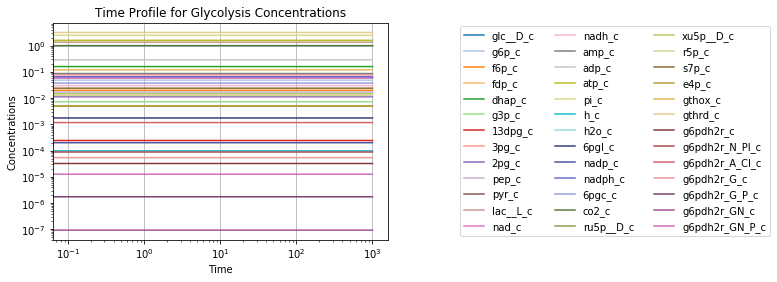

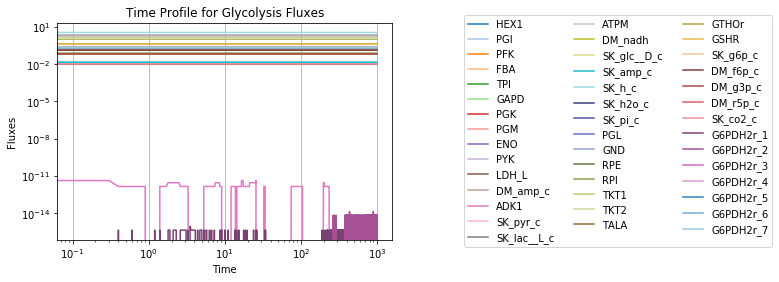

In [28]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(fullppp_G6PDH2r, verbose=True)
sim.find_steady_state(fullppp_G6PDH2r, strategy="nleq2", update_values=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol_list, flux_sol_list = sim.simulate(fullppp_G6PDH2r, time=(0, 1e3, 1e4 + 1))
conc_sol, flux_sol = conc_sol_list[0], flux_sol_list[0]
# Quickly render and display time profiles 
for sol in [conc_sol, flux_sol]:
    sol.view_time_profile
    plt.show()

### Storing information and references
#### Compartment
Because the character "c" represents the cytosol compartment, it is recommended to define and set the compartment in the <font color=#4682B4>EnzymeModule</font><font color=#1E90FF>.compartments</font> attribute.

In [29]:
G6PDH2r.compartments = {"c": "Cytosol"}
print(G6PDH2r.compartments)

{'c': 'Cytosol'}


#### Units
All of the units for the numerical values used in this model are "Millimoles" for amount and "Liters" for volume (giving a concentration unit of 'Millimolar'), and "Hours" for time. In order to ensure that future users understand the numerical values for model, it is important to define the <font color=#4682B4>EnzymeModule</font><font color=#1E90FF>.units</font> attribute.

The <font color=#4682B4>EnzymeModule</font><font color=#1E90FF>.units</font> is a <font color=#008000>cobra</font><font color=#556B2F>.DictList</font> that contains only <font color=#4682B4>UnitDefinition</font> objects from the <font color=#0000FF>mass.core.unit</font> submodule. 

Each <font color=#4682B4>UnitDefinition</font> is created from <font color=#4682B4>Unit</font> objects representing the base units that comprise the <font color=#4682B4>UnitDefinition</font>. These <font color=#4682B4>Units</font> are stored in the <font color=#1E90FF>list_of_units</font> attribute. Pre-built units can be viewed using the <font color=#00008B>print_defined_unit_values</font> function from the <font color=#0000FF>mass.core.unit</font></td> submodule. Alternatively, custom units can also be created using the <font color=#4682B4>UnitDefinition</font><font color=#00008B>.create_unit</font> function.

For more information about units, please see the module docstring for <font color=#0000FF>mass.core.unit</font> submodule.

__Note:__ It is important to note that this attribute will NOT track units, but instead acts as a reference for the user and others so that they can perform necessary unit conversions.

In [30]:
# Using pre-build units to define UnitDefinitions
concentration = UnitDefinition("mM", name="Millimolar", list_of_units=["millimole", "per_litre"])
time = UnitDefinition("hr", name="hour", list_of_units=["hour"])

# Add units to model
G6PDH2r.add_units([concentration, time])
print(G6PDH2r.units)

[<UnitDefinition Millimolar "mM" at 0x12baf1dd8>, <UnitDefinition hour "hr" at 0x12baf1fd0>]


## Export

After validation, the model is ready to be saved. The model can either be exported as a ".json" file or as an ".sbml" (".xml") file using their repsective submodules in <font color=#0000FF>mass.io</font></td>.

To export the model, only the path to the directory and the name of the model need to be specified. Both are shown below. 

In [31]:
filepath = path.realpath(path.join("models", G6PDH2r.id))

### Export using JSON

In [32]:
json.save_json_model(mass_model=G6PDH2r, filename=filepath + ".json")

### Export using SBML

In [33]:
sbml.write_sbml_model(mass_model=G6PDH2r, filename=filepath + ".xml")